In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday October 10 10:11:42 2023
Example Code for training an MRI Image Reconstruction Network from Inter4k Dataset

Methods details in : 
XXX

Trained from Inter4k Dataset.

@author: Dr. Olivier Jaubert
"""

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import numpy as np
import tensorflow as tf
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import shutil
import tqdm
import glob
import tensorflow_io as tfio
import functools
import h5py

# Local imports (works if you are in project folder)
import utils.preprocessing_natural_videos as preproc_filename_2_kspace
import utils.preprocessing_cartesian_VarNet as preproc_cartesian
import utils.display_function as display_func
from utils.subsample_cartesian import generate_mask
from models.variational_network import VarNet , custom_metric_ssim, custom_loss_ssim
import utils.preprocessing_multicoil_noselect as preproc_radial
import utils.preprocessing_trajectory_gen as preproc_traj
#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

2023-10-26 16:23:42.969040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 16:23:43.081590: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 16:23:43.507152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oj20/miniconda3/envs/tf022/lib/:/lib:/home/oj20/miniconda3/lib/:/lib:/home/oj20/miniconda3/lib/:/lib:
2023-10-26 16:23:43.507208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

''

In [2]:
#Configuration
#Use Cardiac Or Natural Images
natural_images=True
DEBUG=False

if DEBUG:
        epochs=25
        config_model={ 'rank':2.5,
              'lbd_trainable':True,
                'num_recon_blocks': 5, 
                'kernel_sizes':[3],
                'unet_layer_sizes': [16,16],
                'block_depth': 2,
                'activation': lambda x:tf.keras.activations.relu(x,alpha=0.1),
                'kernel_initializer': tf.keras.initializers.HeUniform(seed=1)}
else:
        epochs=100
        config_model={ 'rank':2.5,
              'lbd_trainable':True,
                'num_recon_blocks': 12, 
                'kernel_sizes':[3],
                'unet_layer_sizes': [16,32,64],
                'block_depth': 2,
                'activation': lambda x:tf.keras.activations.relu(x,alpha=0.1),
                'kernel_initializer': tf.keras.initializers.HeUniform(seed=1)}
        
config_preproc=preproc_cartesian.config_base_preproc()
config_preproc['phases']=24
config_preproc['base_resolution']=240

#Learning Parameters
learning_rate=0.0001
loss=custom_loss_ssim # had to change code to default norm= False
metrics=custom_metric_ssim # had to change code to default norm= False
# loss=functools.partial(custom_loss_ssim, norm=False)
# metrics=functools.partial(custom_metric_ssim, norm=False)
if natural_images is True:
        config_natural_images={'base_resolution':config_preproc['base_resolution'],'masking':True,
                               'phases':config_preproc['phases'],
                               'regsnr':[12,22],'sigma_coil':[2,6],'complex_transform':4,'num_coils':[30],
                               'add_phase':2, 'clahe': False,
                               }
        size_natural=[244*2,244*6]
        data_folder= '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/'
        experiment_name='Test_VarNet_MC_Inter4k_Cartesian_v5'
else:
        data_folder= '/home/oj20/UCLjob/Project_Video/Datasets/rfh_cine_mri_processed/'
        experiment_name='Test_VarNet_MC_Cardiac_Cartesian_v5'
        
if DEBUG:
        experiment_name=experiment_name+'DEBUG'

config={'experiment_path': 'Training_folder',
        'experiment_name': experiment_name,
        'data_folder': data_folder,
        'split' : [0.75,0.10,0.15], #train, val, test
        'split_mode': 'noshuffle', #noshuffle or random
        'learning_rate': learning_rate,
        'optimizer': tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1),
        'epochs':epochs,
        'loss': loss,
        'metrics':metrics}



In [3]:
acc=14
phases=15
seed_value=7
mask=generate_mask(seed_value,(phases,1,240,240,1),[acc],[8],half_fourier=0.6,mask_type='noreselect')           


In [4]:
# Read files and split data 
train_files=[]
val_files=[]
test_files=[]

file_order=[]
filelist=[]
path_h5_data=os.path.join(config['data_folder'],'*')
for file in tqdm.tqdm(glob.glob(path_h5_data)):
    #file_order.append(int(os.path.basename(file)[-8:-3]))
    filelist.append(file)
if config['split_mode'] == 'random':
    sorted_files =random.shuffle(filelist) 
else:
     
    #sorted_files = [x for x in sorted_files] 
    if natural_images is True:
        
        sorted_files = sorted(filelist,key=lambda x: int(os.path.splitext(os.path.split(x)[-1])[-2]))
        sorted_files = [x for x in sorted_files] 
        list_to_remove=['312.mp4','66.mp4','675.mp4','502.mp4',]
        for bad_element in list_to_remove:
            sorted_files.remove(os.path.join(os.path.split(path_h5_data)[0],bad_element))#this video has frames including only zeros leading to nans
        # sorted_files.remove(os.path.split(path_h5_data)[0]+'/312.mp4')#this video has frames including only zeros leading to nans
    else:
        sorted_files = [x for x in sorted(filelist)]  
if DEBUG:
    n=12
else:
    n=692

#n=len(sorted_files)
ntrain=int(config['split'][0]*n)
nval=int(config['split'][1]*n)
ntest=int(np.ceil(config['split'][2]*n))
#print('leftovers:',n-ntrain-nval-ntest)
train_files.append(sorted_files[:ntrain])
val_files.append(sorted_files[ntrain:ntrain+nval])
test_files.append(sorted_files[ntrain+nval:ntrain+nval+ntest])

train_files=np.concatenate(train_files,axis=0)
val_files=np.concatenate(val_files,axis=0)
test_files=np.concatenate(test_files,axis=0)

# Shuffle files.
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

print('Total/Train/Val/Test:',len(train_files)+len(val_files)+len(test_files),
      '/',len(train_files),'/',len(val_files),'/',len(test_files),'leftovers:',n-ntrain-nval-ntest)

100%|██████████| 1000/1000 [00:00<00:00, 4306266.94it/s]

Total/Train/Val/Test: 692 / 519 / 69 / 104 leftovers: 0


In [5]:
#Util Functions
# For Natural Images
def decode_videos(videofile):
  video = tf.io.read_file(videofile)
  video = tfio.experimental.ffmpeg.decode_video(video,0)
  video=video[:50,...]
  return {'video':video}
def resize_video(video,size=[244*2,244*6]):
  video=video['video']
  video=tf.image.resize(video,size, method='bilinear', preserve_aspect_ratio=True, antialias=False)
  video=tf.cast(tf.clip_by_value(video,0,255),tf.uint8)
  return {'video':tf.ensure_shape(video,(None,)*4)}
# For Cardiac Images
element_spec = {
    '/kspace': tf.TensorSpec(shape=(None,) * 5, dtype=tf.complex64),
}

def _read_hdf5(filename, spec=None):
    """Reads an HDF5 element."""
    io_tensor = tfio.IOTensor.from_hdf5(filename, spec=spec)
    tensors = {k: io_tensor(k).to_tensor() for k in io_tensor.keys}
    return {k: tf.ensure_shape(v, spec[k].shape) for k, v in tensors.items()}

# We need to remove the initial slashes from the keys (e.g. /kspace -> kspace).
def _remove_slashes(structure):
  return {k[1:]: v for k, v in structure.items()}

/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/318.mp4


2023-10-26 16:23:55.154688: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.


(1, 24, 30, 240, 240) <dtype: 'complex64'>


2023-10-26 16:24:06.283600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-10-26 16:24:06.775457: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:24:06.776375: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:24:06.776387: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-26 16:24:06.776771: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:24:06.776813: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


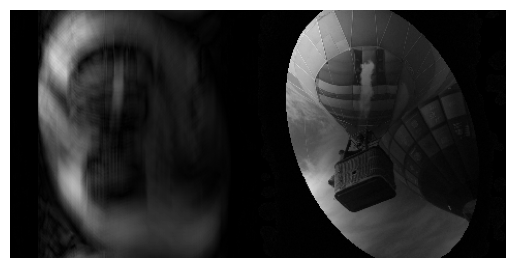

In [6]:
#Define Preprocessing run once to get input shapes
config_natural_images['return_gt']=True
if natural_images:
        preproc_natural_image=preproc_filename_2_kspace.preprocessing_fn(**config_natural_images)
timepoint=10
preproc_function=preproc_cartesian.preprocessing_fn(**config_preproc)
ncase=4#frog 4
for ii,element in enumerate(test_files[ncase:ncase+1]):
        print(train_files[ncase+ii])
        if natural_images:
                video=decode_videos(element)
                video=resize_video(video,size=size_natural)
                kspace=preproc_natural_image(video)
        else:
                with h5py.File(element, 'r') as f:
                        kspace=f['kspace'][:]
                        kspace={'kspace':kspace}
        print(kspace['kspace'].shape,kspace['kspace'].dtype)
        ds0=tf.data.Dataset.from_tensors(kspace)
        dataset_traj=tf.data.Dataset.from_tensors({'mask':mask})
        ds= tf.data.Dataset.zip((ds0,dataset_traj))
        image = ds.map(lambda image, mask: {'image': image, 'trajectory': mask})
        for element2 in image:
                inputs=preproc_function(element2)
                element3=0
                zfill=tf.complex(inputs[element3][timepoint,...,0],inputs[element3][timepoint,...,1])
                element3=-1
                gt=tf.complex(inputs[element3][timepoint,...,0],inputs[element3][timepoint,...,1])
                plt.figure()
                plt.imshow(np.abs(np.concatenate((zfill,gt),axis=1)),vmin=0,vmax=1,cmap='gray')
                plt.axis('off')
                #inputs,gt=roll_function(inputs_temp,gt_temp)

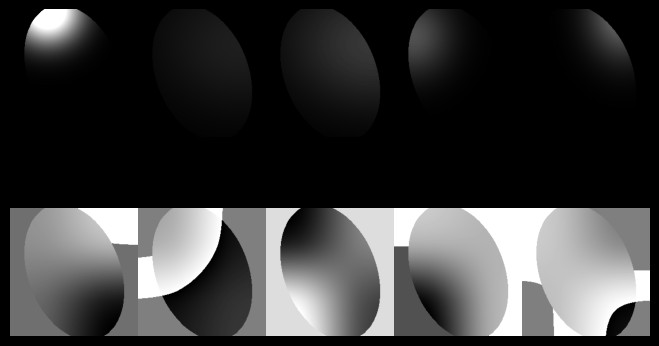

In [7]:
plt.style.use('dark_background')
plt.figure()
for ii in range(5):
    plt.subplot(2,5,ii+1)
    plt.imshow(np.abs(kspace['sensitivities'][ii,:,:]),cmap='gray',vmin=0,vmax=0.5)
    plt.axis('off')
    plt.subplot(2,5,ii+6)
    plt.imshow(np.angle(kspace['sensitivities'][ii,:,:]),cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/Simulate Coils')

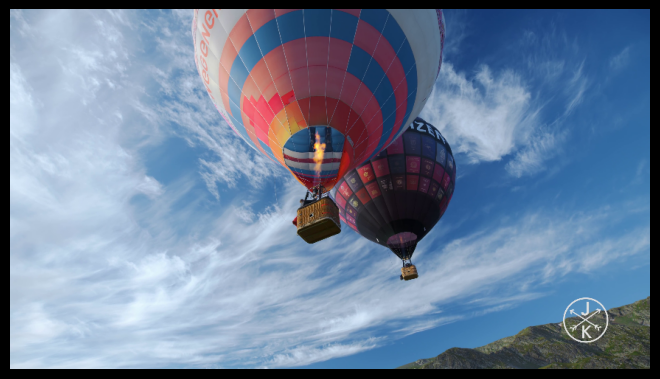

In [8]:
plt.figure()
plt.imshow(video['video'][timepoint,:,:,:],vmin=0,vmax=1,cmap='gray')
plt.axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/RGBVideo')

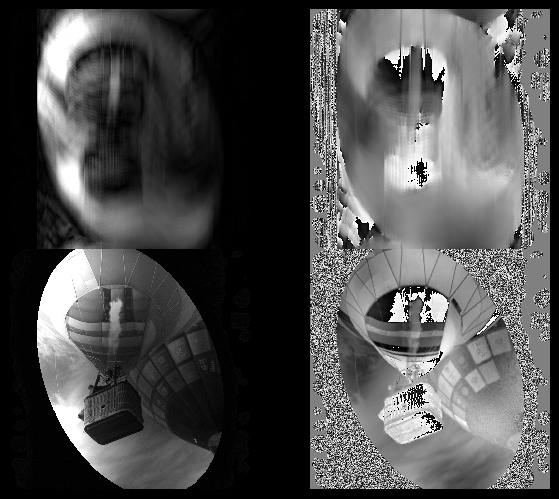

In [11]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(np.concatenate((zfill,gt),axis=0)),vmin=0,vmax=0.6,cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.angle(np.concatenate((zfill,gt),axis=0)),cmap='gray')
plt.axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/ZfillGTimageCartesian')

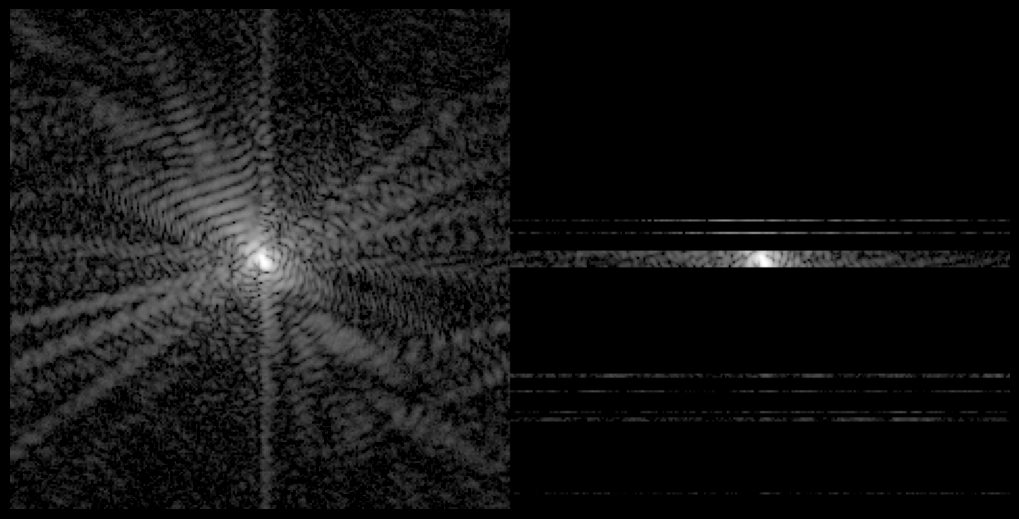

In [10]:
gtkspace=np.log(np.abs(kspace['kspace'][0,timepoint,0,:,:]))
uskspace=gtkspace*mask[timepoint,0,:,:,0]
uskspace[uskspace==0]=-5
plt.figure(figsize=(10,10))
plt.imshow(np.concatenate((gtkspace,uskspace),axis=1),vmin=-5,cmap='gray')
plt.axis('off')

#plt.imshow(np.abs(np.log(np.concatenate((np.abs(gtkspace),np.abs(uskspace)),axis=1))),vmin=0,vmax=10,cmap='gray')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/GTKspaceimageCartesian')

In [11]:
config_traj_spiral=preproc_traj.config_optimized_traj()
config_preproc_spiral=preproc_radial.config_base_preproc()
traj_function=preproc_traj.create_traj_fn(**config_traj_spiral)
preproc_function=preproc_radial.preprocessing_fn(**config_preproc_spiral)
ds0=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds0)
for element in image:
        traj_spiral=element['traj']['traj']
        inputs_spiral,gt_spiral=preproc_function(element)

#Generate Radial
config_preproc_radial=config_preproc_spiral
config_traj_radial=config_traj_spiral
config_traj_radial['phases']=config_preproc['phases']
config_traj_radial['reverse']=True
config_traj_radial['base_resolution']=256
config_preproc_radial['base_resolution']=256
config_traj_radial['radial_spokes']=13
config_traj_radial['ordering']='tiny_half'
traj_function=preproc_traj.create_traj_fn(**config_traj_radial)
preproc_function=preproc_radial.preprocessing_fn(**config_preproc_radial)
ds0=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds0)
for element in image:
        traj_radial=element['traj']['traj']
        inputs_radial,gt_radial=preproc_function(element)


2023-10-26 16:14:33.272910: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:14:33.273227: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:14:33.273248: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-26 16:14:33.273567: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:14:33.273591: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-26 16:14:33.273669: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 16:14:33.273711: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:189] F

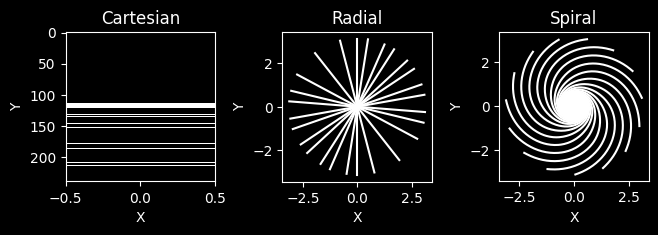

In [19]:
# plt.figure()
# plt.subplot(1,3,1)
# plt.title('Cartesian')
# plt.imshow(np.transpose(np.squeeze(mask)),aspect=15/240,interpolation='nearest',cmap='gray')
# plt.xlabel('Time')
# plt.ylabel('Phase Encoding')
plt.figure()
plt.subplot(1,3,1)
plt.title('Cartesian')
plt.imshow(np.transpose(np.squeeze(mask))[:,1:2],aspect=1/240,interpolation='nearest',cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,3,2, aspect='equal')
plt.title('Radial')
plt.plot(np.transpose(traj_radial[0,:,:,0]),np.transpose(traj_radial[0,:,:,1]),color='w')
#plt.plot(np.transpose(traj_radial[1,:,:,0]),np.transpose(traj_radial[1,:,:,1]),color='w')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,3,3, aspect='equal')
plt.title('Spiral')
plt.plot(np.transpose(traj_spiral[0,:,:,0]),np.transpose(traj_spiral[0,:,:,1]),color='w')
#plt.plot(np.transpose(traj_spiral[1,:,:,0]),np.transpose(traj_spiral[1,:,:,1]),color='w')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout(pad=0.05, w_pad=0.5, h_pad=0)
plt.savefig('Figures/All_Trajectories')

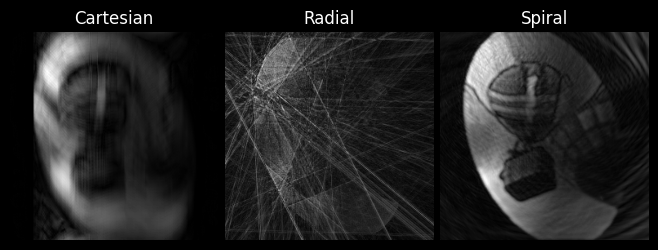

In [13]:
plt.figure()
plt.subplot(1,3,1)
plt.title('Cartesian')
plt.imshow(np.abs(zfill),cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Radial')
radial_zfill=np.abs(tfmri.combine_coils(tf.complex(inputs_radial[:,:,timepoint,:10],inputs_radial[:,:,timepoint,10:]),coil_axis=-1))
plt.imshow(radial_zfill,cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Spiral')
spiral_zfill=np.abs(tfmri.combine_coils(tf.complex(inputs_spiral[:,:,timepoint,:10],inputs_spiral[:,:,timepoint,10:]),coil_axis=-1))
plt.imshow(spiral_zfill,cmap='gray')
plt.axis('off')

plt.tight_layout(pad=0.05, w_pad=0.5, h_pad=0)
plt.savefig('Figures/Zfill_All_Trajectories')

In [ ]:
# #tempk=kspace['kspace']
# plt.figure(figsize=(20,5))
# #cropsides=150+19
# cropsides=1
# maxlen=10
# timepoint0=5
# for ii in range(0,maxlen):
#     plt.subplot(2,maxlen,ii+1)
#     plt.imshow(np.abs(tempk[0,timepoint0,ii,:,cropsides:-cropsides]),vmax=np.mean(np.abs(tempk[0,0,:,:,:]))*3)
#     plt.axis('off')
#     plt.subplot(2,maxlen,maxlen+ii+1)
#     plt.imshow(np.abs(kspace['kspace'][0,timepoint0,ii,:,:]),vmax=np.mean(np.abs(kspace['kspace'][0,0,:,:,:]))*3)
#     plt.axis('off')
# #images
# plt.figure(figsize=(20,5))
# im=tfmri.signal.ifft(tempk[0,timepoint0,:,:,cropsides:-cropsides], axes=[-2, -1], norm='ortho', shift=True)
# tempim=tfmri.signal.ifft(kspace['kspace'][0,timepoint0,:,:,:], axes=[-2, -1], norm='ortho', shift=True)
# for ii in range(0,maxlen):
#     plt.subplot(2,maxlen,ii+1)
#     plt.imshow(np.abs(im[ii,:,:]),vmax=np.max(np.abs(im[ii,:,:]))/2,cmap='gray')
#     plt.axis('off')
#     plt.subplot(2,maxlen,maxlen+ii+1)
#     plt.imshow(np.abs(tempim[ii,:,:]),vmax=np.max(np.abs(tempim[ii,:,:]))/2,cmap='gray')
#     plt.axis('off')

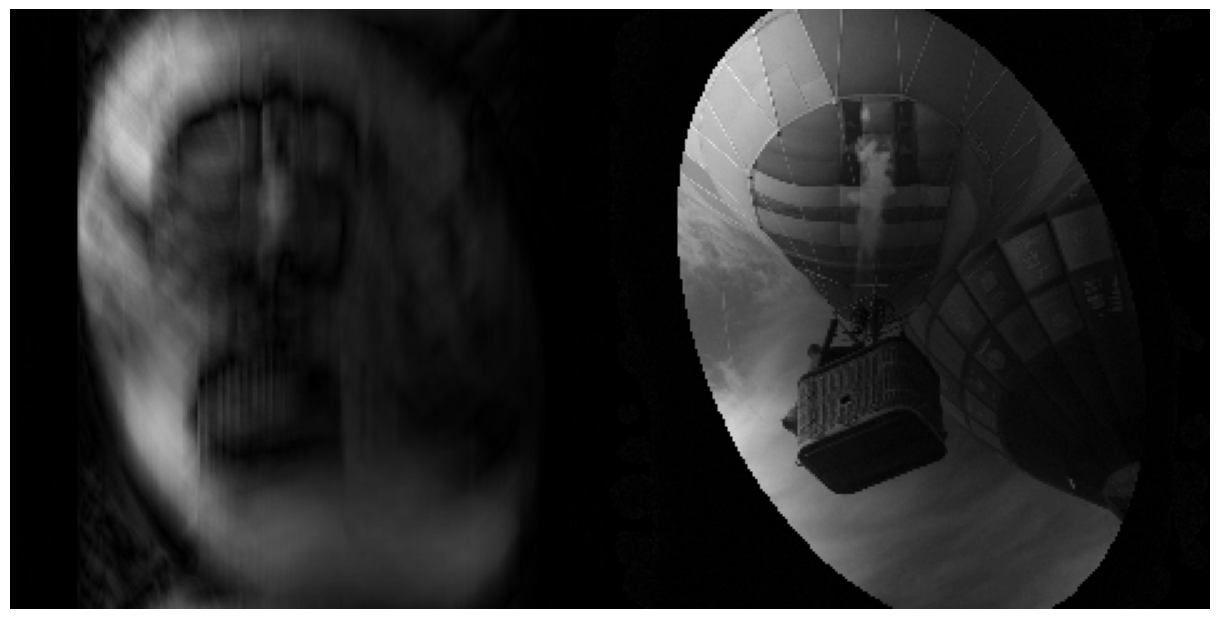

In [14]:
element=0
zfill=tf.complex(inputs[element][...,0],inputs[element][...,1])
element=-1
gt=tf.complex(inputs[element][...,0],inputs[element][...,1])
display_func.plotVid(np.abs(np.concatenate((zfill,gt),axis=2)),axis=0,figsize=(12,6),vmin=0,vmax=1,interval=50)
#display_func.plotVid(np.angle(np.concatenate((zfill,gt),axis=2)),axis=0,figsize=(12,6),vmin=-3.1415,vmax=3.1415,interval=50)
# from scipy.interpolate import interp1d
# x = np.arange(0, inputs[-1].shape[0])
# yreal = inputs[-1][...,0]
# yimag= inputs[-1][...,1]
# freal = interp1d(x, yreal,axis=0)
# fimag = interp1d(x, yimag,axis=0)
# step=0.5
# xnew=np.arange(0, inputs[-1].shape[0]-(1-step+10**-3),step)
# yrealnew = freal(xnew)
# yimagnew= fimag(xnew)
# gt=tf.complex(yrealnew,yimagnew)
#display_func.plotVid(np.concatenate((np.real(gt),np.imag(gt)),axis=2),axis=0,figsize=(12,6),vmin=0,vmax=1,interval=50)

#display_func.plotVid(np.concatenate((np.abs(newgt),(np.angle(newgt)+np.pi)/(2*np.pi)),axis=2),axis=0,figsize=(12,6),vmin=0,vmax=1,interval=50)
#display_func.plotVid(np.abs(np.concatenate((zfill,gt),axis=2)),axis=0,figsize=(12,6),vmin=0,vmax=1,interval=200)


In [ ]:
# #Creating Tensorflow dataset

# # Create datasets.
# dataset_dir='/home/oj20/UCLjob/Project_Video/Datasets/'
# cache_initial=dataset_dir+'/cache_Inter4K_preproc/trainv2/'
# cache_initial_val=dataset_dir+'/cache_Inter4K_preproc/valv2/'
# cache_initial_test=dataset_dir+'/cache_Inter4K_preproc/testv2/'
# shutil.rmtree(cache_initial, ignore_errors=True, onerror=None)
# os.makedirs(cache_initial,exist_ok=True)
# shutil.rmtree(cache_initial_val, ignore_errors=True, onerror=None)
# os.makedirs(cache_initial_val,exist_ok=True)
# shutil.rmtree(cache_initial_test, ignore_errors=True, onerror=None)
# os.makedirs(cache_initial_test,exist_ok=True)
# datasets=[train_files,val_files,test_files]
# preproc_datasets=[]
# for pp,dataset in enumerate(datasets):
#     dataset = tf.data.Dataset.from_tensor_slices(
#         tf.convert_to_tensor(list(map(str, dataset)), dtype=tf.string))
#     dataset=dataset.map(decode_videos,num_parallel_calls=3)
#     dataset=dataset.map(functools.partial(resize_video,size=size_natural),num_parallel_calls=3)
#     if pp==0:
#         dataset=dataset.cache(cache_initial)
#     elif pp==1:
#         dataset=dataset.cache(cache_initial_val)
#     elif pp==2:
#         dataset=dataset.cache(cache_initial_test)
#     preproc_datasets.append(dataset)

# counter=0
# datasets=[train_files,val_files,test_files]
# for dataset in preproc_datasets:
#     for x in dataset:
#         counter+=1
#         print("\r",counter, end="")


In [ ]:
dataset_dir='/home/oj20/UCLjob/Project_Video/Datasets/'
cache_initial=dataset_dir+'/cache_Inter4K_preproc/trainv2/'
cache_initial_val=dataset_dir+'/cache_Inter4K_preproc/valv2/'
cache_initial_test=dataset_dir+'/cache_Inter4K_preproc/testv2/'
if natural_images:
    cache_folder=dataset_dir+'/cache_inter4k_varnet'+str(os.environ['CUDA_VISIBLE_DEVICES'])+'/'
    cache_folder2=dataset_dir+'/cache_inter4k_varnet_val'+str(os.environ['CUDA_VISIBLE_DEVICES'])+'/'
else:
    cache_folder=dataset_dir+'/cache_varnet_mc'+str(os.environ['CUDA_VISIBLE_DEVICES'])+'/'
    cache_folder2=dataset_dir+'/cache_varnet_mc_val'+str(os.environ['CUDA_VISIBLE_DEVICES'])+'/'
shutil.rmtree(cache_folder, ignore_errors=True, onerror=None)
shutil.rmtree(cache_folder2, ignore_errors=True, onerror=None)
os.makedirs(cache_folder,exist_ok=True)
os.makedirs(cache_folder2,exist_ok=True)

datasets=[train_files,val_files,test_files]
dataset_withtransforms=[]
for pp,dataset in enumerate(datasets):
    dataset = tf.data.Dataset.from_tensor_slices(
        tf.convert_to_tensor(list(map(str, dataset)), dtype=tf.string))
    if natural_images:
        dataset=dataset.map(decode_videos,num_parallel_calls=1)
        dataset=dataset.map(functools.partial(resize_video,size=size_natural),num_parallel_calls=1)
        if pp==0:
            dataset=dataset.cache(cache_initial)
        elif pp==1:
            dataset=dataset.cache(cache_initial_val)
        elif pp==2:
            dataset=dataset.cache(cache_initial_test)
        dataset=dataset.map(preproc_natural_image,num_parallel_calls=1)
    else:
        dataset=dataset.map(functools.partial(_read_hdf5, spec=element_spec))
        dataset = dataset.map(_remove_slashes)
    dataset_traj=tf.data.Dataset.from_tensors({'mask':mask}).repeat(-1)
    ds= tf.data.Dataset.zip((dataset,dataset_traj))
    dataset = ds.map(lambda image, mask: {'image': image, 'trajectory': mask})
    dataset=dataset.map(preproc_function,num_parallel_calls=1)
    if pp==0:
        dataset=dataset.cache(cache_folder)
    #dataset=dataset.map(roll_function,num_parallel_calls=1)
    dataset=dataset.shuffle(buffer_size=4,seed=1)
    if pp==1:
        dataset=dataset.cache(cache_folder2)

    dataset=dataset.batch(1,drop_remainder=True)
    dataset=dataset.prefetch(4)
    dataset_withtransforms.append(dataset)

In [ ]:
datasets[0]

array(['/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/421.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/393.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/190.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/201.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/318.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/486.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/452.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/412.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/97.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/273.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/81.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/509.mp4',
       '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/445.mp4',
 

In [ ]:
# #Problem with element 15 of train dataset (full of zeros or sensitivities at 0 maybe try to remove it later)
# pp=15
# for ii,element in enumerate(dataset_withtransforms[0].skip(pp).take(1)):
#     print(ii)
#     print(train_files[ii+pp])
#     gt=tf.complex(element[-1][0,11,...,0],element[-1][0,11,...,1])
#     plt.figure()
#     plt.imshow(np.abs(gt),vmin=0,vmax=1,cmap='gray')
#     plt.axis('off')

In [ ]:
#Defining Paths
path = config['experiment_path']
exp_name = os.path.splitext(os.path.basename(config['experiment_name']))[0]
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(path, exp_name)

#Define and compile Model
# image_inputs= tf.keras.Input(inputs.shape)
# outputs=tfmri.models.UNet3D(**config_model)(image_inputs)
# model=tf.keras.Model(inputs=image_inputs,outputs=outputs)

model=VarNet(**config_model)
_ = model(next(iter(dataset_withtransforms[0])))

model.compile(optimizer=config['optimizer'],
                    loss=config['loss'],
                    metrics=config['metrics'] or None,
                    run_eagerly=False)

model.summary()
callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))
# display_fn=display_func.display_fn(complex_part='abs',input_shape='varnet',output_shape='complex')
# # display_fn=display_func.display_fn(complex_part='abs',input_shape='multicoil')
# callbacks.append(tfmri.callbacks.TensorBoardImages(log_dir=os.path.join(exp_dir,'logs'),
#      max_images=1,volume_mode='gif',x= dataset_withtransforms[1],display_fn=display_fn,images_freq=5))
# callbacks.append(tfmri.callbacks.TensorBoardImages(log_dir=os.path.join(exp_dir,'logs'),
#      max_images=2,volume_mode='gif',x= dataset_withtransforms[1]))


2023-09-28 10:28:23.687587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:28:26.245255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:28:28.417760: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "var_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vn_recon_cell_u_net (VNReco  multiple                 43299     
 nCellUNet)                                                      
                                                                 
 vn_recon_cell_u_net_1 (VNRe  multiple                 43299     
 conCellUNet)                                                    
                                                                 
 vn_recon_cell_u_net_2 (VNRe  multiple                 43299     
 conCellUNet)                                                    
                                                                 
 vn_recon_cell_u_net_3 (VNRe  multiple                 43299     
 conCellUNet)                                                    
                                                                 
 vn_recon_cell_u_net_4 (VNRe  multiple                 4329

In [ ]:
#Save Configuration
if not DEBUG:
    import json
    os.makedirs(exp_dir,exist_ok=True)
    file2save={'config.json':config.copy(),'config_preproc.json':config_preproc.copy(),'config_model.json':config_model.copy()}
    if natural_images is True:
        file2save['config_natural.json']=config_natural_images.copy()
    for key in file2save.keys():
        print(key)
        temp_config=file2save[key]
        for key2 in temp_config.keys():
            temp_config[key2]=str(temp_config[key2])
        with open(os.path.join(exp_dir,key), 'w') as f:
            f.write(json.dumps(temp_config))

In [ ]:
#Train Model
history=model.fit(dataset_withtransforms[0],
          epochs=config['epochs'],
          verbose=1,
          callbacks=callbacks,
          validation_data=dataset_withtransforms[1])

Epoch 1/25


9/9 [==============================] - ETA: 0s - loss: 0.8622

2023-09-28 10:29:11.445654: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:29:23.456551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:29:26.039880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:29:28.293792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 73s 6s/step - loss: 0.8622 - val_loss: 0.8675
Epoch 2/25


2023-09-28 10:29:41.945838: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


9/9 [==============================] - ETA: 0s - loss: 0.7235

2023-09-28 10:30:15.822409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:30:26.500989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:30:29.148588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:30:31.446263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 63s 6s/step - loss: 0.7235 - val_loss: 0.6385


2023-09-28 10:30:45.335078: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/25


2023-09-28 10:30:55.627887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:30:58.214933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.6201

2023-09-28 10:31:19.659782: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:31:30.335556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:31:32.989913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:31:35.293346: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 64s 6s/step - loss: 0.6201 - val_loss: 0.5964


2023-09-28 10:31:49.183087: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/25


2023-09-28 10:32:00.232653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:32:05.459694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.5727

2023-09-28 10:32:26.878262: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:32:37.226144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:32:39.770976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:32:41.981859: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 67s 6s/step - loss: 0.5727 - val_loss: 0.5418
Epoch 5/25


2023-09-28 10:32:56.199238: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:33:06.519075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:33:09.076110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.5039

2023-09-28 10:33:30.212140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:33:40.741275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:33:43.374444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 49s 4s/step - loss: 0.5039 - val_loss: 0.5575


2023-09-28 10:33:45.700120: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:33:45.770272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6/25


2023-09-28 10:33:56.127579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:33:58.772654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4990

2023-09-28 10:34:20.216164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:34:30.833690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:34:33.474661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:34:35.779917: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 64s 6s/step - loss: 0.4990 - val_loss: 0.4331
Epoch 7/25


2023-09-28 10:34:50.009835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:35:00.341872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:35:02.943404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4749

2023-09-28 10:35:24.877991: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:35:35.489652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:35:38.116202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 50s 5s/step - loss: 0.4749 - val_loss: 0.5308


2023-09-28 10:35:40.473606: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:35:40.536819: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8/25


2023-09-28 10:35:51.765017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:35:56.837419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4729

2023-09-28 10:36:18.346136: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:36:28.777698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:36:31.397800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 53s 5s/step - loss: 0.4729 - val_loss: 0.4629


2023-09-28 10:36:33.709715: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:36:33.777446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9/25


2023-09-28 10:36:44.104998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:36:46.713444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4742

2023-09-28 10:37:08.369307: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:37:18.825306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:37:21.513754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 50s 5s/step - loss: 0.4742 - val_loss: 0.5428


2023-09-28 10:37:23.882754: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:37:23.946198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10/25


2023-09-28 10:37:34.299789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:37:36.896762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4457

2023-09-28 10:37:58.631182: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:38:09.369833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:38:12.057422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 50s 5s/step - loss: 0.4457 - val_loss: 0.4764


2023-09-28 10:38:14.372139: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:38:14.439964: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 11/25


2023-09-28 10:38:24.842887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:38:27.427973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4304

2023-09-28 10:38:49.072938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:38:59.742130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:39:02.361339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:39:04.642601: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 64s 6s/step - loss: 0.4304 - val_loss: 0.4259


2023-09-28 10:39:18.520839: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 12/25


2023-09-28 10:39:28.916277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:39:31.532402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4376

2023-09-28 10:39:53.264133: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:40:03.753821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:40:06.349385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 50s 5s/step - loss: 0.4376 - val_loss: 0.5232


2023-09-28 10:40:08.675820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:40:08.749919: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 13/25


2023-09-28 10:40:20.856089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:40:23.434565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3951

2023-09-28 10:40:44.972628: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:40:55.575583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:40:58.229454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 52s 5s/step - loss: 0.3951 - val_loss: 0.5122


2023-09-28 10:41:00.555674: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:41:00.629240: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 14/25


2023-09-28 10:41:11.502904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:41:16.691404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4341

2023-09-28 10:41:37.874027: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:41:48.373697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:41:50.991465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:41:53.281620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 67s 6s/step - loss: 0.4341 - val_loss: 0.4259
Epoch 15/25


2023-09-28 10:42:07.371850: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:42:17.657272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:42:20.305535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4272

2023-09-28 10:42:41.813332: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:42:52.388351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:42:55.064474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 50s 5s/step - loss: 0.4272 - val_loss: 0.4909


2023-09-28 10:42:57.395679: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:42:57.461740: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 16/25


2023-09-28 10:43:08.481628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:43:13.616870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3986

2023-09-28 10:43:34.565868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:43:45.229188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:43:47.874372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 53s 4s/step - loss: 0.3986 - val_loss: 0.4721


2023-09-28 10:43:50.181193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:43:50.245074: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 17/25


2023-09-28 10:44:01.391116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:44:06.557026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4191

2023-09-28 10:44:27.741442: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:44:38.353974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:44:40.989768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:44:43.351824: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 67s 6s/step - loss: 0.4191 - val_loss: 0.3915
Epoch 18/25


2023-09-28 10:44:57.650011: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:45:07.963927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:45:10.511082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.4022

2023-09-28 10:45:32.005482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:45:42.536505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:45:45.240744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 50s 5s/step - loss: 0.4022 - val_loss: 0.4525


2023-09-28 10:45:47.552375: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:45:47.620609: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 19/25


2023-09-28 10:45:58.634210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:46:03.780016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3726

2023-09-28 10:46:24.888009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:46:35.575751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:46:38.198305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 53s 5s/step - loss: 0.3726 - val_loss: 0.4043


2023-09-28 10:46:40.509093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:46:40.575079: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 20/25


2023-09-28 10:46:51.318538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:46:56.449237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3756

2023-09-28 10:47:17.671607: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:47:28.202603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:47:30.833092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 52s 5s/step - loss: 0.3756 - val_loss: 0.4503


2023-09-28 10:47:33.181535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:47:33.251079: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 21/25


2023-09-28 10:47:44.131020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:47:49.245108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3827

2023-09-28 10:48:10.296123: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:48:20.846902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:48:23.494771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:48:25.808582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 66s 6s/step - loss: 0.3827 - val_loss: 0.3887
Epoch 22/25


2023-09-28 10:48:39.611600: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


9/9 [==============================] - ETA: 0s - loss: 0.3836

2023-09-28 10:49:13.610603: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:49:24.220327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:49:26.888968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 49s 5s/step - loss: 0.3836 - val_loss: 0.4960


2023-09-28 10:49:29.215720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:49:29.288114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 23/25


2023-09-28 10:49:40.314653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:49:45.509575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3923

2023-09-28 10:50:06.767394: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:50:17.315981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:50:19.930687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 53s 4s/step - loss: 0.3923 - val_loss: 0.4370


2023-09-28 10:50:22.212355: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:50:22.290086: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 24/25


2023-09-28 10:50:33.357941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:50:38.435510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3742

2023-09-28 10:50:59.683940: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:51:10.255358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:51:12.885558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - 53s 5s/step - loss: 0.3742 - val_loss: 0.3921


2023-09-28 10:51:15.220843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:51:15.285782: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 25/25


2023-09-28 10:51:26.197499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:51:31.341953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


9/9 [==============================] - ETA: 0s - loss: 0.3840

2023-09-28 10:51:52.550140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-28 10:52:03.108825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-09-28 10:52:05.692764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-09-28 10:52:07.995793: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model/assets


9/9 [==============================] - 67s 6s/step - loss: 0.3840 - val_loss: 0.3519


2023-09-28 10:52:22.372305: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
#Evaluate On Test Set
import json
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
model.load_weights(checkpoint_filepath)
result = model.evaluate(dataset_withtransforms[2])
#results_dict=dict(zip(model.metrics_names, result))
results_dict={model.metrics_names[0]: result} #when only 1 metric
filename = os.path.join(exp_dir,'results.json')
with open(filename, 'w') as f:
    f.write(json.dumps(results_dict))

2023-09-28 10:52:22.725575: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model: FAILED_PRECONDITION: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-09-28 10:52:38.400004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 4
2023-09-28 10:52:50.286480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:52:50.286750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2/2 [==============================] - 28s 214ms/step - loss: 0.3274


2023-09-28 10:52:51.197304: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model: FAILED_PRECONDITION: Training_folder/Test_VarNet_MC_Inter4k_Cartesian_cardiaccoils_claheimages_lbdfix01_20230928_102812/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-09-28 10:53:10.353813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 4
2023-09-28 10:53:21.740051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-09-28 10:53:21.740522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


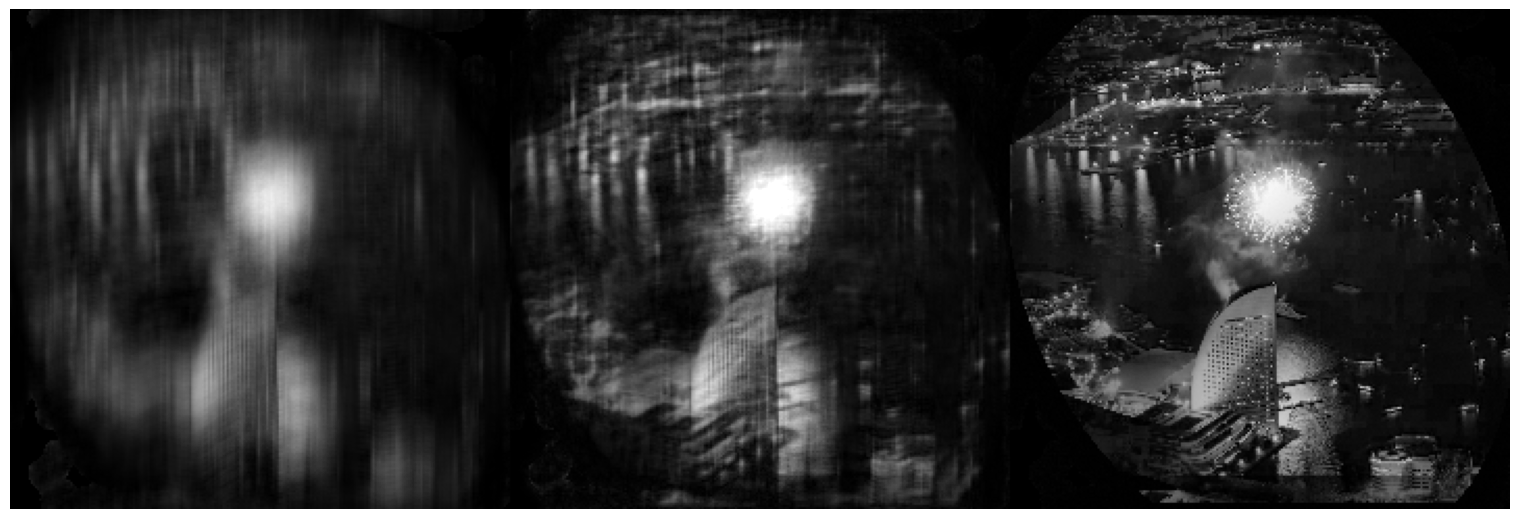

In [ ]:
#Inference
#Preproc series 1
model.load_weights(checkpoint_filepath)
inputs=next(iter(dataset_withtransforms[-1]))
output = model(inputs)
element=0
zfill=tf.complex(inputs[element][0,...,0],inputs[element][0,...,1])
element=-1
gt=tf.complex(inputs[element][0,...,0],inputs[element][0,...,1])
output=tf.complex(output[0,...,0],output[0,...,1])

#From Left to Right: Input, Ground Truth, Reconstructed.
plot_image=np.abs(np.concatenate((zfill,output,gt),axis=2))
savepath=os.path.join(exp_dir,'video_varnet')
display_func.plotVid(plot_image,axis=0,vmin=0,vmax=1,interval=41.66,savepath=savepath)
